In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import random


## Group Assignment
### Team Number: 3
### Team Member Names: Jeffrey Zhao, Bethany Liu, Ray Wang
### Team Strategy Chosen: Safe

Our team decided to aim for the **SAFEST** portfolio.

The overall thought process behind our solution combines different key topics and calculations that we've learned throughout this course. Strategies we thought of to obtain the safest portfolio include:

- **SMALLEST** standard deviation
- **SMALLEST** beta
- most **NEGATIVELY CORRELATED** stocks
- the **MOST** stocks as possible (22) (diversification)

These ideas will be seen and expanded upon throughout the rest of our code.
Here is a brief overview:


Blueprint of the code:
- Read in CSV File
- Get rid of tickers that don't meet requirements
- Calculate standard deviation
- Calculate beta
- Determine optimal portfolio by taking the 26 stock of smallest std + beta value
- Calculate correlation between each stock and get rid of 4 stocks with highest correlation
- Calculate optimal weightings on each stock
- Generate final portfolio
- Test portfolio

(Side note: Although it was discussed, our team did not decide to try and earn back our transaction fees. We decided that in the grand scheme of things, if we buy 20 stocks, the fee will only be $\$100$ which is extremely minimal compared to our $\$750000$ portfolio. ($\$100$ is approximately 0.013% of $\$750000$). Furthermore, we also tried looking at investing in different industries, however, .info is broken.)

In [2]:
# Read in CSV file and filter out tickers that do not meet the requirements

# Requirements:
# - Stock must be denominated in either USD or CAD
# - Stocks must have an average monthly volume of at least 150,000 shares between Jan 1 - Oct 31, 2023
# - Stocks must have at least 18 trading days

# Read in CSV file
tickers_data = pd.read_csv('Tickers.csv', header=None) #dataframe for tickers file, change to 'Tickers' after we finish the code
tickers_data.set_index(tickers_data.columns[0], inplace=True)

# using these dates for data for now, can be changed later
start_date = '2023-01-01'
end_date = '2023-10-31'

# create function to get data of every stock
print("Please ignore error messages from yfinance")

def get_stock_data(ticker_df):
  complete_stock_data = pd.DataFrame()
  for i in ticker_df.index: # for loop to get every element of the dataframe
    ticker = yf.Ticker(i)
    stock_history = ticker.history(start=start_date, end=end_date)
    if stock_history.empty:
      continue
    currency = ticker.fast_info['currency']

    # ignore stocks that have monthly volume of less than 150000 and stocks that are not listed in cad or usd
    if (monthly_volume(stock_history)>150000 and (currency == 'CAD'or currency == 'USD')):
        complete_stock_data[i] = stock_history.Close.pct_change()

  complete_stock_data.index = complete_stock_data.index.date

  return complete_stock_data

# create function to get the average monthly volume from january 1st to october 31st, get rid of months that have less than 18 trading days
def monthly_volume(df):
  min_trading_days = 18
  trading_days_per_month = df.resample('M').size() # find number of trading days per month
  valid_months = trading_days_per_month[trading_days_per_month >= min_trading_days].index # check if the number of days is greater than 18

  # compute average volume
  total_volume = 0
  for month in valid_months:
     total_volume += df[df.index.month == month.month].Volume.mean()
  return total_volume/len(valid_months)

# main
complete_portfolio = get_stock_data(tickers_data)
print("Complete portfolio of all the stocks in the ticker file:", '\n')
complete_portfolio.head()

Please ignore error messages from yfinance


WWEAA: No timezone found, symbol may be delisted
PAPL: Data doesn't exist for startDate = 1672549200, endDate = 1698724800
INVALIDT: No timezone found, symbol may be delisted
HDFC.NS: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
CELG: No timezone found, symbol may be delisted


Complete portfolio of all the stocks in the ticker file: 



,AAPL,ABBV,BMO.TO,AMZN,OTEX.TO,SU.TO,BMBL,BK,SQ,VZ,...,TD.TO,T.TO,SLB,SO,SPG,SHOP.TO,CNI,CNR.TO,GWO.TO,K.TO
2023-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04,0.010314,0.008067,0.014141,-0.007924,0.019455,-0.026647,0.002935,0.024622,0.025681,0.025175,...,0.013003,0.012158,0.003884,0.008484,0.030798,0.037303,0.015188,0.001044,0.019035,0.048028
2023-01-05,-0.010605,-0.001222,-0.001822,-0.023726,-0.025525,0.023644,-0.041463,-0.004848,-0.023982,0.013858,...,-0.016392,-0.001126,0.018762,-0.029375,-0.030868,-0.035171,-0.023392,-0.015517,0.013387,-0.014730
2023-01-06,0.036794,0.018717,0.014922,0.035611,0.003182,0.025043,-0.008142,0.015675,0.066141,0.011751,...,-0.000463,0.015408,0.034745,0.017761,0.012349,0.014950,0.035294,0.024421,0.022734,0.019933
2023-01-09,0.004089,-0.029361,-0.001173,0.014870,0.007077,0.000712,0.029246,0.003962,0.001015,-0.004020,...,-0.003126,-0.002221,0.020917,-0.001815,-0.004627,0.005044,0.006213,0.002250,0.006308,-0.014658


**Calculating the Standard Deviation**

From the modules, we learned that the standard deviation of a stock is the calculation of a stocks volatility (the tendancy for the stock price to change). So in order to achieve the safest portfolio (least change), we want to have stocks with the lowest standard deviation. Therefore, we started off by calculating the standard deviation of the percentage returns of each stock in order to compare each of their volatilities.


In [3]:
# create function to calculate the standard deviation
def standard_deviation(df):
  std = pd.DataFrame()
  std = df.std()
  return std

print("Standard deviation of the percentage returns for each stock in the portfolio")
display(standard_deviation(complete_portfolio))

Standard deviation of the percentage returns for each stock in the portfolio


AAPL       0.013131
ABBV       0.012926
BMO.TO     0.010566
AMZN       0.022147
OTEX.TO    0.017620
SU.TO      0.017195
BMBL       0.030728
BK         0.015908
SQ         0.031708
VZ         0.015363
CMCSA      0.015594
SHOP       0.036526
COST       0.011641
CSCO       0.011772
CVS        0.015477
PPL.TO     0.010651
GOOG       0.020249
IBM        0.010395
ORCL       0.018001
TD.TO      0.010770
T.TO       0.010399
SLB        0.021785
SO         0.011803
SPG        0.015494
SHOP.TO    0.035591
CNI        0.012546
CNR.TO     0.011025
GWO.TO     0.008581
K.TO       0.021878
dtype: float64

**Calculating the Beta**

We also learned that the beta is also a measure of the volaility of a security's return. However, it measures it in comparison to the market. We decided to consider this since we want our stocks to be less correlated to the market, meaning that it would be less influenced by the fluctuations in the market. (For the market, we decided to use the S&P 500 as it would give the best indication to how the market is doing)

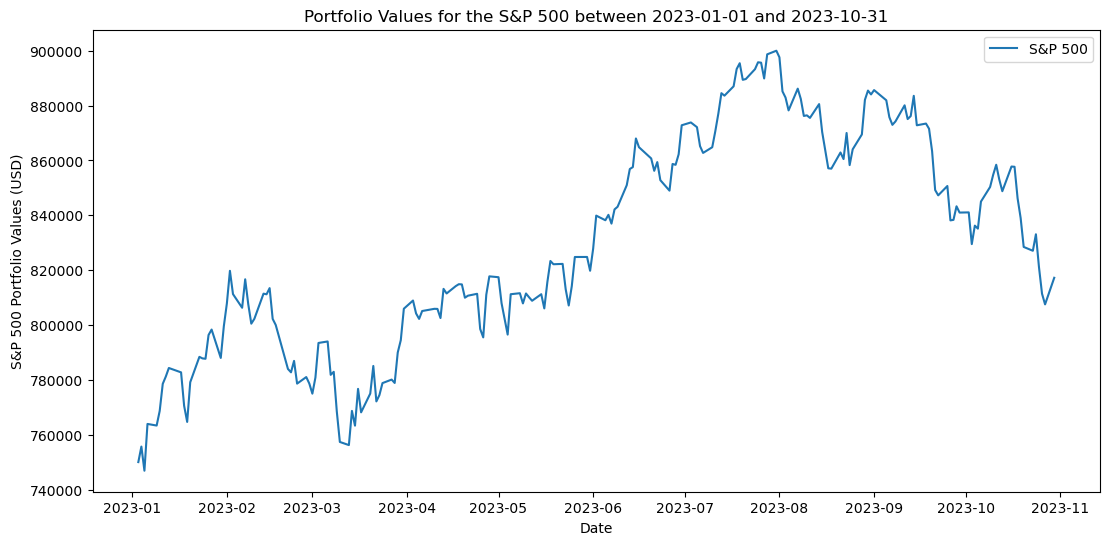

The standard deviation of the S&P 500 is 0.008505661514818396
The capital gain of the S&P 500 between 2023-01-01 and 2023-10-31 is 67207.25599742634


In [4]:
# graph the closing prices of the market
start_date1 = '2023-01-01'
end_date1 = '2023-10-31'
investment = 750000

# import S&P 500
MarketIndex='^GSPC'
Ticker2 = yf.Ticker(MarketIndex)
MarketIndex_hist = Ticker2.history(start=start_date, end=end_date)
shares = investment/MarketIndex_hist['Close'].iloc[0]
Market_portfolio = MarketIndex_hist['Close']*shares
Marketdf = MarketIndex_hist['Close'].pct_change()
Marketdf.index = Marketdf.index.date

plt.figure(figsize = (13,6))
plt.plot(Market_portfolio, label = "S&P 500")
plt.title(f"Portfolio Values for the S&P 500 between {start_date1} and {end_date1}")
plt.xlabel("Date")
plt.ylabel("S&P 500 Portfolio Values (USD)")
plt.legend()
plt.show()

print("The standard deviation of the S&P 500 is", MarketIndex_hist['Close'].pct_change().std())
print(f"The capital gain of the S&P 500 between {start_date1} and {end_date1} is {abs(Market_portfolio.iloc[-1] - Market_portfolio.iloc[0])}")

From above, we can see that the market seems to change constantly between the beginning of this year. So, we decided that it is not optimal for the stocks we choose to be highly correlated with the market as it would then also be as volatile as the market.

In [5]:
# calculate the beta
# takes in a dataframe with the close prices and outputs a dataframe of one row containing all the betas for each stock
'''
Beta 	 Meaning
1.0	The stock moves in line with the broader market
2.0	The stock moves twice as much as the broader market
0.0	The stock's moves don’t correlate with the broader market
-1.0	The stock moves in the opposite direction of the broader market
'''

def beta(df):
  #create dataframe for the beta values
  betadf = pd.DataFrame()
  for i in df.columns:
    #create a dataframe with a single stocks prices and the market index
    prices = pd.DataFrame()
    prices[i] = df[i]
    prices[MarketIndex] = Marketdf
    #calculate variance of market
    MarketVar = prices[MarketIndex].var()
    #drop first row since NA
    prices.drop(index=prices.index[0], inplace=True)
    #calculate beta which returns a 2x2 dataframe
    betacalc = prices.cov()/MarketVar
    #select the value for the beta of the selected stock
    betadf[i] = pd.Series(betacalc.iat[0,1])

  return betadf

print("The beta for each stock is:", '\n')
display(beta(complete_portfolio))

The beta for each stock is: 



,AAPL,ABBV,BMO.TO,AMZN,OTEX.TO,SU.TO,BMBL,BK,SQ,VZ,...,TD.TO,T.TO,SLB,SO,SPG,SHOP.TO,CNI,CNR.TO,GWO.TO,K.TO
0,1.138706,0.183694,0.754321,1.609614,1.014831,0.456743,1.440756,1.010575,2.118502,0.480266,...,0.629537,0.38102,0.793937,0.448569,1.059294,2.056271,0.837513,0.592201,0.352464,0.309306


**Adding the Standard Deviation and Beta**

After calculating the standard deviation and beta of each stock, we decided to add the two values together to determine the extent of its volatility and compare it with the other stocks. We chose to priioritize the standard deviation of the stock more than its beta since the standard deviation is more of an indicator of a stock's volatility than its beta. Therefore, we chose a weighting of 70% on the standard deviation and 30% on the beta.

In [6]:
# add standard deviation and beta

# market movement is not as impactful as the volatility of the stock itself so put weighting on each in relation to importance
std_weight = 0.7
beta_weight = 0.3

# function to calculate the sum of the standard deviation and beta
def add_std_and_beta(std, beta):
  std_and_beta = pd.DataFrame()
  std_and_beta = std*std_weight*100 + abs(beta)*beta_weight
  return std_and_beta

std_and_beta = add_std_and_beta(standard_deviation(complete_portfolio), beta(complete_portfolio))
display(std_and_beta)

,AAPL,ABBV,BMO.TO,AMZN,OTEX.TO,SU.TO,BMBL,BK,SQ,VZ,...,TD.TO,T.TO,SLB,SO,SPG,SHOP.TO,CNI,CNR.TO,GWO.TO,K.TO
0,1.260769,0.959909,0.965911,2.033173,1.537863,1.340704,2.583199,1.416746,2.855089,1.219493,...,0.94274,0.842212,1.763145,0.960808,1.402394,3.108263,1.129461,0.949384,0.706433,1.624266


After calculating the sum, we then took the top 24 stocks with the lowest standard deviation and beta to filter out stocks with the highest volatility.

In [7]:
# get the top 24 stocks with least standard deviation and beta
# returns a dataframe with the list of 24 tickers from the least volatile to most volatile based off our calculations
portfolio = pd.DataFrame()
def get_portfolio(std_and_beta):
   std_and_beta = std_and_beta.iloc[0, :].sort_values()
   if len(std_and_beta) >= 22:
    portfolio = pd.DataFrame(std_and_beta.head(min(24, len(std_and_beta))))
   else:
    portfolio = std_and_beta


   return portfolio

# main
generated_portfolio = get_portfolio(std_and_beta)
generated_portfolio.rename(columns={0: 'Std and Beta value'}, inplace=True)
display(generated_portfolio)

,Std and Beta value
GWO.TO,0.706433
T.TO,0.842212
IBM,0.871682
PPL.TO,0.900656
TD.TO,0.942740
CNR.TO,0.949384
ABBV,0.959909
SO,0.960808
BMO.TO,0.965911
CSCO,1.050163


**Calculating the Correlation**

Next, we calculated the correlation between each of our 24 chosen stocks. To obtain the safest portfolio, it is important to have a diversified portfolio, meaning that the stocks that we choose should have as minimal of a correlation as possible (optimal would be a perfect negative correlation, which means 0 capital gain/loss, however that is extremely difficult to obtain). After calculating the correlation between each stock, we get rid of 2 stocks (one in each pair) of the highest correlation in attempts to divsersify the industries of the different stocks (the higher the correlation, the more likely they are to be in the same industry).

In [8]:
# calculate correlation between each chosen stock
correlation = get_stock_data(generated_portfolio).corr()

# filter out stocks with a correlation greater than 0.75 or 1 (same stock)
correlation = (correlation[(correlation<.75) | (correlation == 1)])
print("The beginning of the dataframe containing the correlations between the stocks is:")
display(correlation.head())

The beginning of the dataframe containing the correlations between the stocks is:


,GWO.TO,T.TO,IBM,PPL.TO,TD.TO,CNR.TO,ABBV,SO,BMO.TO,CSCO,...,AAPL,SU.TO,CMCSA,SPG,BK,OTEX.TO,ORCL,K.TO,SLB,GOOG
GWO.TO,1.000000,0.228658,0.246956,0.320875,0.436332,0.197355,0.144488,0.081152,0.490517,0.150457,...,0.160517,0.170662,0.162442,0.347175,0.405037,0.119267,0.194179,-0.013992,0.217379,0.077874
T.TO,0.228658,1.000000,0.142134,0.359361,0.262417,0.312272,0.103727,0.420174,0.345169,0.194293,...,0.179842,0.063576,0.214869,0.277773,0.249201,0.210312,0.076386,0.250101,0.048524,0.114262
IBM,0.246956,0.142134,1.000000,0.271417,0.316050,0.171487,0.191725,0.245280,0.385947,0.358609,...,0.177274,0.107615,0.183153,0.412426,0.372983,0.150563,0.303454,0.034515,0.221678,0.087867
PPL.TO,0.320875,0.359361,0.271417,1.000000,0.474737,0.444711,0.123509,0.212999,0.563273,0.232119,...,0.144421,0.650109,0.124901,0.416555,0.506000,0.182097,0.108390,0.134332,0.592381,0.070013
TD.TO,0.436332,0.262417,0.316050,0.474737,1.000000,0.355866,0.113514,0.163601,0.713988,0.169473,...,0.286617,0.402155,0.229655,0.484725,0.540201,0.208402,0.167137,0.146190,0.440335,0.143344


**Removing high correlation stocks**

We go through the portfolio in reverse by considering the columns of the correlation dataframe, If there is a NaN value in the column, it means this ticker has a high correlation with another ticker. We then compare the row indices for when there is NaN value, and if the row indices are still in the portfolio, we remove the column ticker from the portfolio. If the row indices do not appear in the portfolio, it means it has aleady been removed previously. In this case we do not remove the column because we still want to keep at least one stock from a pair that has high correlation

In [9]:
columns_reverse = list(reversed(correlation.columns))
for i in columns_reverse:
  if correlation[i].isnull().any() and len(generated_portfolio)>=10: # if there is a correlation value that is higher than 0.75, than it would be filtered out as NaN in the table
    null_indices = correlation.loc[correlation[i].isnull()].index # find the row indices where the the correlation is higher than 0.75
    common_indices = generated_portfolio.index.intersection(null_indices) # find the row indices that are also in the portfolio
    if common_indices.size != 0: # if there's no intersection, it means the row index has already been removed from the portfolio, so no need to remove the column as well
      print('The removed ticker is', i)
      generated_portfolio = generated_portfolio.drop(i) # if common row indices is not empty, get rid of the ticker of the column

if len(generated_portfolio>22): # after eliminating the high correlation stocks, if the number of stocks we have is greater than the required amount of 22, just take only the first 22 stocks
  generated_portfolio = generated_portfolio.head(22)
print('The updated portfolio after removing high correlation stocks:')
display(generated_portfolio)

The removed ticker is CNI
The updated portfolio after removing high correlation stocks:


,Std and Beta value
GWO.TO,0.706433
T.TO,0.842212
IBM,0.871682
PPL.TO,0.900656
TD.TO,0.942740
CNR.TO,0.949384
ABBV,0.959909
SO,0.960808
BMO.TO,0.965911
CSCO,1.050163


**Calculating the Optimal Weighting on Each Stock**

After removing the high correlation stocks, we are left with the stocks we want to keep in our portfolio. The way we are going to determine weighting is to linearly increase the weighting every stock starting from the most volatile one. We are giving the volatile stocks less weighting so that it has less of an influence on the portfolio. The formula to generate the weighting is determined by the arithmetic sum formula with the sum being 100 and the starting value being 100/(2*number of tickers)



In [10]:
# determine weighting/percentage of each stock
# using arithmetic sequence sum formula Sn = n/2(2a+(n-1)d), calculate the difference in weighting between each stock
# to evenly space out weighting of every stock, with the most volatile ones being the least weighted, least volatile being most weighted
# choose starting value, a, to be the minimum weighted value, 100/(2*n), as stated by the rules
n=len(generated_portfolio) # number of stocks
S = 100 # weighting has to add up to 100%
a = 100/(2*n)
d = ((S*2/n)-2*a)/(n-1)
print("Difference in weighting between each stock:", d)
print("Weighting of the most volatile stock:", a)
print("Weighting of the least volatile stock:", a+21*d)

def create_final_portfolio(df):
  Portfolio_Final = pd.DataFrame(columns=['Ticker', 'Price', 'Currency', 'Shares', 'Values', 'Weight'], index=range(1, len(df)+1))
  start_date = '2023-11-21'
  end_date = '2023-11-21'
  usd_to_cad = yf.Ticker('USDCAD=x')
  exchange_rate = usd_to_cad.fast_info['previousClose']

  investment = 750000
  count = 1
  for i in df.index:
    investment = investment - 4.95 # subtract out the fees for the buying the stock

    ticker = yf.Ticker(i)
    stock_price = ticker.fast_info['previousClose'] # take the last close price of the stock
    currency = ticker.fast_info['currency']
    weight = a+(n-count)*d # calculates weighting of the stock

    Portfolio_Final.loc[count, 'Ticker'] = i
    Portfolio_Final.loc[count, 'Price'] = stock_price
    Portfolio_Final.loc[count, 'Currency'] = currency
    Portfolio_Final.loc[count, 'Weight'] = round(weight,2)
    if currency == 'USD':
     stock_price = stock_price*exchange_rate # turn stock price into CAD

    shares_values = investment*weight/100 # find value of this stock in CAD in the portfolio
    num_shares = shares_values/stock_price
    Portfolio_Final.loc[count, 'Shares'] = round(num_shares,2)
    Portfolio_Final.loc[count, 'Values'] = round(shares_values,2)

    count += 1

  columns_to_sum = Portfolio_Final[['Values','Weight']]
  Portfolio_Final.loc['Total'] = columns_to_sum.sum(axis=0)
  return Portfolio_Final
  #Ticker, Price, Currency, Shares, Value, Weight. Ticker will be the ticker your code selected, Price is the price on November 25, 2023,
  #Currency is either USD or CAD, Shares is the number of shares you purchased of that stock,
  #Value is the total value of those shares, and Weight is the weight that the value of shares represents relative to the value of your portfolio

final_portfolio = create_final_portfolio(generated_portfolio)

Difference in weighting between each stock: 0.21645021645021648
Weighting of the most volatile stock: 2.272727272727273
Weighting of the least volatile stock: 6.818181818181818


/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:633: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not _np.isnan(quotes["High"][n - 1]):
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:634: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/Users/j52zhao/anaconda3/lib/python3.11/site-packages/yfinance/utils.py:638: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

**Test Runs**

Now that we have our final portfolio, we need to test to see whether or not it works. We do this through building our portfolio by investing the determined weighting on each stock and adding the returns for of each invetment. We then compute the overall capital gain/loss and the standard deviation of the portfolio to compare the results.

Our test trials consist of the results of the most recent week, month and year to guage how well our code works.

In [11]:
# Basic imports

# begining investment
investment = 750000 #(an estimation)

# import chosen tickers
test_tickers = final_portfolio['Ticker'].iloc[:-1].tolist()
print(test_tickers)

['GWO.TO', 'T.TO', 'IBM', 'PPL.TO', 'TD.TO', 'CNR.TO', 'ABBV', 'SO', 'BMO.TO', 'CSCO', 'COST', 'VZ', 'CVS', 'AAPL', 'SU.TO', 'CMCSA', 'SPG', 'BK', 'OTEX.TO', 'ORCL', 'K.TO', 'SLB']


,GWO.TO,T.TO,IBM,PPL.TO,TD.TO,CNR.TO,ABBV,SO,BMO.TO,CSCO,...,CVS,AAPL,SU.TO,CMCSA,SPG,BK,OTEX.TO,ORCL,K.TO,SLB
2023-11-16,51150.000000,49500.000000,47925.000000,46275.000000,44625.000000,43050.000000,41400.000000,39750.000000,38175.000000,36525.000000,...,31650.000000,30000.000000,28425.000000,26775.000000,25125.000000,23550.000000,21900.000000,20325.000000,18675.000000,17025.000000
2023-11-17,51402.744348,49316.741767,47871.771447,47004.325351,45146.865248,43359.831934,41405.989130,39864.276022,38511.887311,36312.112936,...,31909.691176,29996.836602,29547.460289,26781.312310,25387.892826,23914.802687,21945.427680,20447.301385,18201.270462,17266.766714
2023-11-20,52124.863756,49276.020736,48328.917813,47268.572732,45317.270807,43151.451801,41408.981411,39675.728214,38391.570414,36699.869549,...,31654.638353,30275.155264,29298.731768,27109.607813,25611.142642,23874.268197,22065.190700,20723.807454,18226.202464,17230.829362
2023-11-21,52437.777364,49072.400045,48191.147544,47194.583788,44848.656535,42986.938307,41534.725729,39795.714768,38047.806353,36342.525788,...,31571.165684,30147.065412,28967.095382,26894.953154,25402.497895,23778.001680,21912.390808,20574.919987,18575.267214,17224.294958
2023-11-22,52425.747229,48970.587758,48573.145189,47374.270071,44390.690833,42712.751940,41456.885313,39761.429782,37961.865338,36555.412852,...,32062.724992,30253.016307,28731.126653,26819.193394,25266.878491,23924.936310,21891.739989,20603.278925,18949.266356,17158.952165


2023-11-16    750000.000000
2023-11-17    753730.131323
2023-11-20    756527.852361
2023-11-21    755004.535981
2023-11-22    755728.671136
dtype: float64

The capital gain/loss is, 5728.671135884593
The standard deviation of the final portfolio is 0.003105382360120187


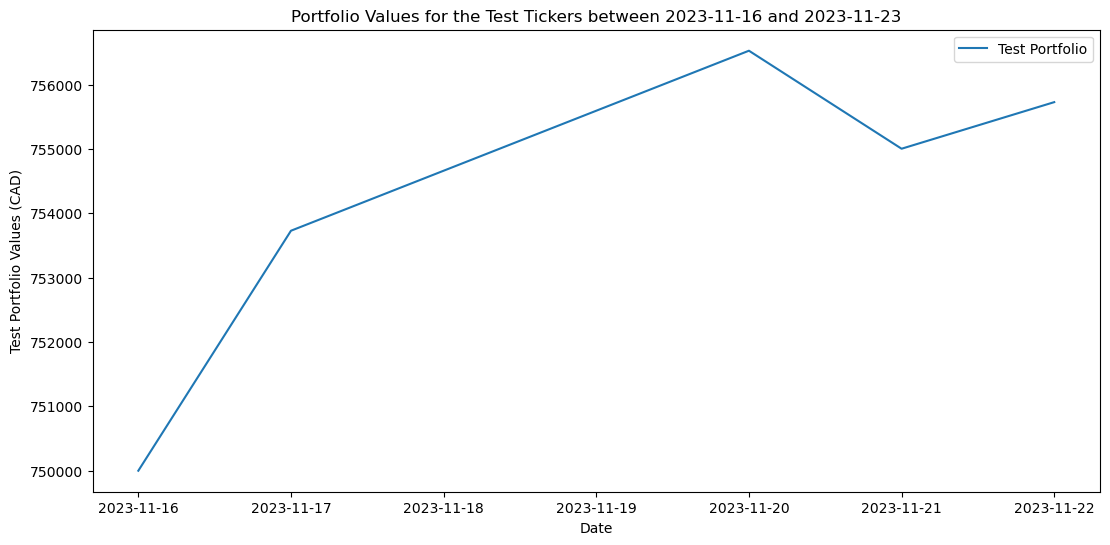

In [12]:
# Test 1: 1 Week (2023-11-16 - 2023-11-23)

# change dates here
test1_start_date = '2023-11-16'
test1_end_date = '2023-11-23'

# get the closing prices of each ticker multiplied by the respective number of shares
def get_test_portfolio(test_tickers, start_date, end_date):
  closing = pd.DataFrame()
  count = 0

  for ticker in test_tickers:
    hist = yf.Ticker(ticker).history(start = start_date, end = end_date)
    shares = (final_portfolio['Weight'].iloc[count]*0.01*investment)/hist['Close'].iloc[0]
    closing[ticker] = hist['Close']*shares
    count += 1

  return closing

# main
test1_portfolio = get_test_portfolio(test_tickers, test1_start_date, test1_end_date)
test1_portfolio = test1_portfolio.dropna()
test1_portfolio.index = test1_portfolio.index.date
display(test1_portfolio.head())

# get the final diversified portfolio
final_test1_portfolio = test1_portfolio.sum(axis=1)
display(final_test1_portfolio.head())

def plot_portfolio(test_portfolio, start_date, end_date):
  # beginning value - ending value
  print("The capital gain/loss is,", abs(test_portfolio.iloc[-1] - test_portfolio.iloc[0]))
  print("The standard deviation of the final portfolio is", test_portfolio.pct_change().std())

  # plot graph
  plt.figure(figsize = (13,6))
  plt.plot(test_portfolio, label = "Test Portfolio")
  plt.title(f"Portfolio Values for the Test Tickers between {start_date} and {end_date}")
  plt.xlabel("Date")
  plt.ylabel("Test Portfolio Values (CAD)")
  plt.legend()
  plt.show()

# main
plot_portfolio(final_test1_portfolio, test1_start_date, test1_end_date)

,GWO.TO,T.TO,IBM,PPL.TO,TD.TO,CNR.TO,ABBV,SO,BMO.TO,CSCO,...,CVS,AAPL,SU.TO,CMCSA,SPG,BK,OTEX.TO,ORCL,K.TO,SLB
2023-10-02,51150.000000,49500.000000,47925.000000,46275.000000,44625.000000,43050.000000,41400.000000,39750.000000,38175.000000,36525.000000,...,31650.000000,30000.000000,28425.000000,26775.000000,25125.000000,23550.000000,21900.000000,20325.000000,18675.000000,17025.000000
2023-10-03,50015.110493,49801.121114,47785.442755,45661.085868,44203.222935,43044.079583,41171.003907,40586.708496,37559.493729,36288.264921,...,31450.171757,29766.906984,28536.715706,26320.673085,24822.435126,23130.165864,21432.872937,19907.871965,19114.412420,17221.872351
2023-10-04,50215.386325,51399.390889,48016.900092,45441.006111,44086.680108,43289.724964,41243.613159,40960.693744,37699.692967,36152.986627,...,31327.551073,29984.461697,27171.321761,26332.788746,25079.376185,23085.383470,21758.028838,20395.473973,18957.479950,16405.001790
2023-10-05,50696.044197,52395.414018,48170.066913,45684.252856,44058.930001,43269.005762,41176.590227,40941.672702,37891.183513,35895.958127,...,31677.247876,30200.288465,27202.356165,26060.192135,25103.389008,23337.283089,22000.752310,20637.369467,19177.185407,16278.651162
2023-10-06,51443.727921,52233.267122,48343.661229,45962.252292,44286.469021,43313.402117,41397.206840,41182.544847,37877.503539,36152.986627,...,31745.372809,30645.757639,27326.479402,26332.788746,25072.172521,23594.784551,22101.504620,20944.026049,19679.370815,16366.802476


2023-10-02    750000.000000
2023-10-03    745842.550579
2023-10-04    746977.184430
2023-10-05    749982.474727
2023-10-06    753072.190139
dtype: float64

The capital gain/loss is, 2982.108271775185
The standard deviation of the final portfolio is 0.007432088052408069


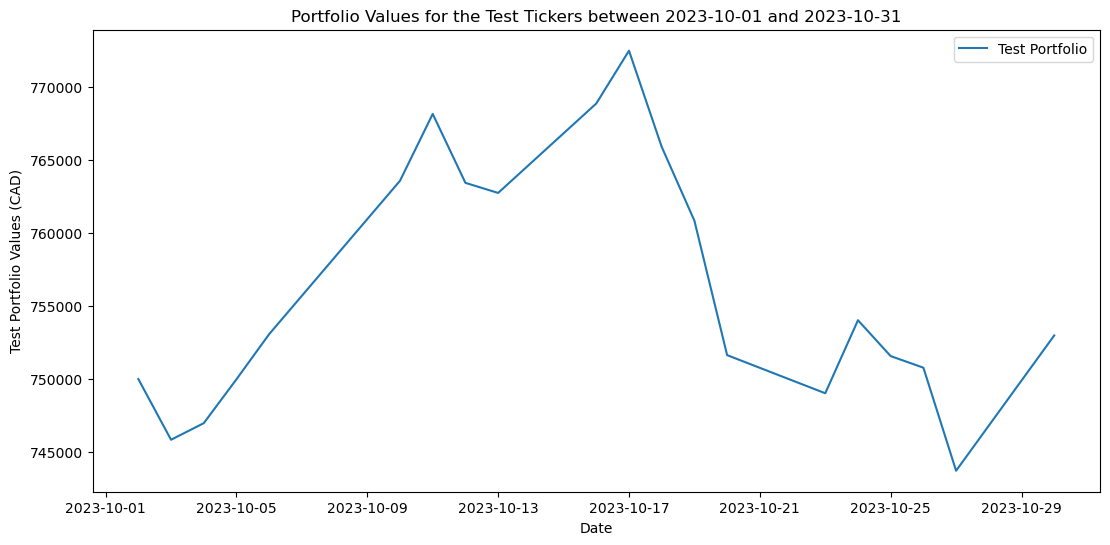

In [13]:
# Test 2: 1 Month (2023-10-01 - 2023-10-31)

test2_start_date = '2023-10-01'
test2_end_date = '2023-10-31'

# get portfolio
test2_portfolio = get_test_portfolio(test_tickers, test2_start_date, test2_end_date)
test2_portfolio = test2_portfolio.dropna()
test2_portfolio.index = test2_portfolio.index.date
display(test2_portfolio.head())

# get the final diversified portfolio
final_test2_portfolio = test2_portfolio.sum(axis=1)
display(final_test2_portfolio.head())

# plot graph
plot_portfolio(final_test2_portfolio, test2_start_date, test2_end_date)

,GWO.TO,T.TO,IBM,PPL.TO,TD.TO,CNR.TO,ABBV,SO,BMO.TO,CSCO,...,CVS,AAPL,SU.TO,CMCSA,SPG,BK,OTEX.TO,ORCL,K.TO,SLB
2023-01-03,51150.000000,49500.000000,47925.000000,46275.000000,44625.000000,43050.000000,41400.000000,39750.000000,38175.000000,36525.000000,...,31650.000000,30000.000000,28425.000000,26775.000000,25125.000000,23550.000000,21900.000000,20325.000000,18675.000000,17025.000000
2023-01-04,52123.664561,50101.825814,48280.507493,46141.610873,45205.273725,43094.930376,41734.000129,40087.236565,38714.835216,36517.322615,...,31333.192459,30309.428493,27667.552339,27542.795077,25898.802674,24129.847352,22326.071174,20509.507785,19571.913621,17091.116704
2023-01-05,52821.463912,50045.408271,47776.025018,46418.640994,44464.291250,42426.240905,41683.005611,38909.659290,38644.286196,36002.776092,...,30811.993562,29988.007033,28321.713562,27836.366112,25099.351436,24012.859476,21756.202802,20468.235911,19283.620125,17411.780925
2023-01-06,54022.316000,50816.494202,48652.923256,47106.102670,44443.704160,43462.313599,42463.178428,39600.724447,39220.932267,37108.666949,...,31203.742544,31091.387625,29030.959783,28521.359327,25409.298528,24389.255075,21825.439108,20795.981488,19668.011453,18016.746716
2023-01-09,54363.102185,50703.651627,48602.144218,47516.517816,44304.772458,43560.102278,41216.433497,39528.854935,39174.922998,37308.338858,...,31166.273165,31218.520071,29051.613211,28265.430568,25291.731918,24485.896970,21979.889648,21059.157614,19379.717957,18393.610903


2023-01-03    750000.000000
2023-01-04    757647.106086
2023-01-05    753430.602814
2023-01-06    769019.287996
2023-01-09    768282.656787
dtype: float64

The capital gain/loss is, 24368.109048544662
The standard deviation of the final portfolio is 0.006593778951181846


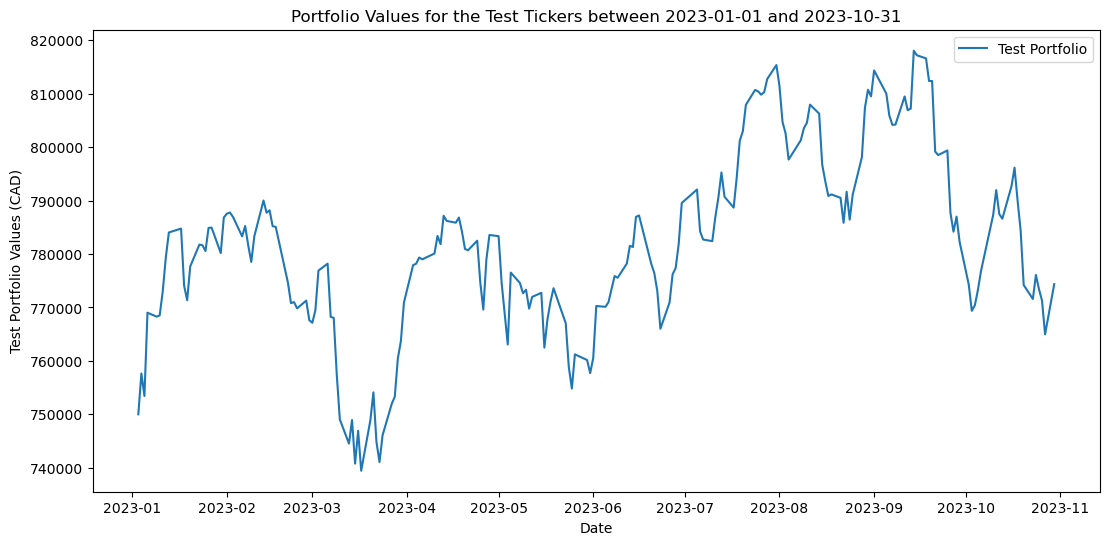

In [14]:
# Test 3: (approximately) 1 Year (2023-01-01 - 2023-11-24)

test3_start_date = '2023-01-01'
test3_end_date = '2023-10-31'

# get portfolio
test3_portfolio = get_test_portfolio(test_tickers, test3_start_date, test3_end_date)
test3_portfolio = test3_portfolio.dropna()
test3_portfolio.index = test3_portfolio.index.date
display(test3_portfolio.head())

# get the final diversified portfolio
final_test3_portfolio = test3_portfolio.sum(axis=1)

display(final_test3_portfolio.head())

# plot graph
plot_portfolio(final_test3_portfolio, test3_start_date, test3_end_date)

**Comparing our portoflio with the S&P 500**

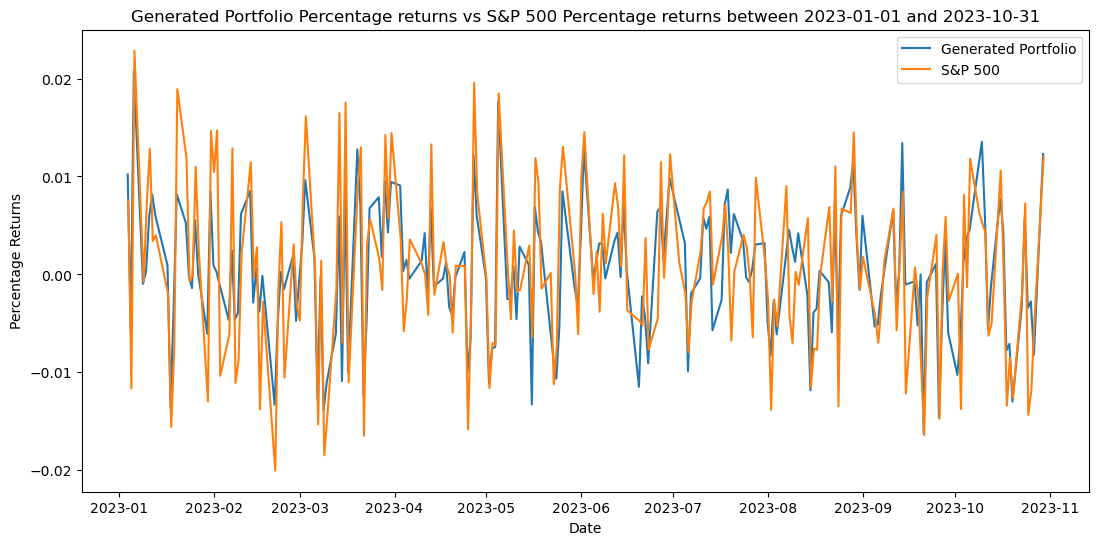

In [15]:

plt.figure(figsize = (13,6))
plt.plot(final_test3_portfolio.pct_change(), label = "Generated Portfolio")
plt.plot(Market_portfolio.pct_change(), label = "S&P 500")
plt.title(f"Generated Portfolio Percentage returns vs S&P 500 Percentage returns between {test3_start_date} and {test3_end_date}")
plt.xlabel("Date")
plt.ylabel("Percentage Returns")
plt.legend()
plt.show()

**Test Results**

From the 3 tests conducted above, it is clear to see that our portfolio does not reach a 0 return in any case. However, the standard deviation on all three are extremely low (Test 1: 0.002, Test 2: 0.008, Test 3: 0.006) indicating that our code is still works in finding a less volatile portfolio. Furthermore, when comparing the percentage returns of our portfolio with the percentage returns of the S&P 500, we can see that in general, our portfolio is less volatile.

**Finishing Touches**

After finalizing and testing the data required to create our safe portfolio, we can now output the final portfolio...

In [16]:
display(final_portfolio)

,Ticker,Price,Currency,Shares,Values,Weight
1,GWO.TO,43.349998,CAD,1179.61,51136.03,6.82
2,T.TO,24.290001,CAD,2038.38,49512.33,6.6
3,IBM,158.520004,USD,222.84,47888.66,6.39
4,PPL.TO,45.360001,CAD,1019.95,46265.01,6.17
5,TD.TO,82.639999,CAD,540.19,44641.38,5.95
6,CNR.TO,157.279999,CAD,273.51,43017.78,5.74
7,ABBV,142.320007,USD,214.55,41394.19,5.52
8,SO,70.949997,USD,413.48,39770.63,5.3
9,BMO.TO,111.610001,CAD,341.79,38147.08,5.09
10,CSCO,48.389999,USD,556.75,36523.56,4.87


... and convert it to csv.

In [17]:
# output to csv file
Stocks_Final = final_portfolio[['Ticker', 'Shares']]
Stocks_Final = Stocks_Final.drop(index = 'Total')

display(Stocks_Final)

Stocks_Final.to_csv('Stocks_Group_03.csv', index = True)

,Ticker,Shares
1,GWO.TO,1179.61
2,T.TO,2038.38
3,IBM,222.84
4,PPL.TO,1019.95
5,TD.TO,540.19
6,CNR.TO,273.51
7,ABBV,214.55
8,SO,413.48
9,BMO.TO,341.79
10,CSCO,556.75


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Jeffrey Zhao, Bethany Liu, Ray Wang

**THE END**